In [1]:
%matplotlib notebook
from brian2 import *
from matplotlib.pyplot import *
import numpy as np
import random
from IPython.display import clear_output

In [2]:
def data_generator(num, pixels=256, objects=1, object_width=20, width=6, rand_width=6, speed_range=(1, 30),
                   label_delay=0, state_change=0.05, left=0.3, right=0.3, noise=0.00, loop_around=False):
    # Input
    # num           Number of images
    # pixels        Image resolution
    # objects       Number of moving objects
    # object_width  Length between object contours
    # width         Width of contours
    # rand_width    Random change in width (+|-)
    # speed_range   Random range of the speed for the object
    # label_delay   Adds a delay to answers to prevent labelling of jitter
    # state_change  Likelihood of changing movement
    # left          Likelihood of moving left
    # right         Likelihood of moving right (not moving = 1 - (left+right))
    # noise         Likelihood of a pixel being turned white
    # loop_around   Object appears on the other side when out of frame
    #
    # Output
    # data          Array of 1D images (pixelsx1). Use imshow(data) to view
    # labels        -1 means left movement, 0 no movement and 1 right movement

    data = np.zeros((num, pixels, 3))
    labels = {}
    labels["left"] = np.zeros(num)
    labels["right"] = np.zeros(num)

    for l in range(objects):
        # Init
        label_count = label_delay
        r = np.random.rand()
        if r < left:
            state = -1
        elif r < left + right:
            state = 1
        else:
            state = 0
        last_pos = random.randrange(0, pixels - 1)

        # Go through each time step
        for i in range(num):
            speed = random.randrange(speed_range[0], speed_range[1])

            # Randomly change state
            if state_change > np.random.rand():
                label_count = label_delay
                r = np.random.rand()
                if r < left:
                    state = -1
                elif r < left + right:
                    state = 1
                else:
                    state = 0

            label_count -= 1

            # Move object
            pos = last_pos + speed * state
            if loop_around:
                if pos > pixels - 1:
                    pos = 0
                elif last_pos < 0:
                    pos = pixels - 1
            else:
                if pos > pixels - 1:
                    state = -1
                    pos = last_pos + speed * state
                elif last_pos < 0:
                    state = 1
                    pos = last_pos + speed * state

            # Paint contours
            if state != 0:
                # Left contour
                width_now = width + round(rand_width * np.random.rand() * 2 - rand_width / 2)
                pos_offset = pos - int(object_width / 2)
                for j in range(width_now + 1):
                    if j % 2 == 0:
                        index = pos_offset - int(j / 2)
                    else:
                        index = pos_offset + int(j / 2 + 1)
                    if index >= 0 and index < pixels:
                        data[i][index].fill(1)

                # Right contour
                width_now = width + round(rand_width * np.random.rand() * 2 - rand_width / 2)
                pos_offset = pos + int(object_width / 2)
                for j in range(width_now + 1):
                    if j % 2 == 0:
                        index = pos_offset - int(j / 2)
                    else:
                        index = pos_offset + int(j / 2 + 1)
                    if index >= 0 and index < pixels:
                        data[i][index].fill(1)

            # Write labels
            last_pos = pos
            if label_count < 0:
                if state == -1:
                    labels["left"][i] += 1
                elif state == 1:
                    labels["right"][i] += 1

    if noise > 0:
        data = random_noise(data, noise)

    labels = labels["right"] - labels["left"]
    return data, labels


def random_noise(data, noise):
    for img in data:
        for i in range(int(2 * np.random.rand() * noise * len(img))):
            index = random.randrange(0, len(img))
            img[index].fill(1)

    return data

In [4]:
start_scope()
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
th : 1
'''

taupre = taupost = 100*ms
wmax = 2
wmin = 0.001
Apre = 0.0005
Apost = -Apre*taupre/taupost*1.5


#S=NeuronGroup(512, eqs, threshold='v>1', reset='v = 0', method='exact')
S=NeuronGroup(256, eqs, threshold='v>1', reset='v = 0', method='exact')

E = NeuronGroup(150, eqs, threshold='v>1', reset='v = 0', method='exact')


I = NeuronGroup(150, eqs, threshold='v>0.5', reset='v = 0', method='exact')


StE= Synapses(S, E,'''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, wmin, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, wmin, wmax)
             ''')
StE.connect(p=1)

#EtE= Synapses(E, E,'''
#             w : 1
#             dapre/dt = -apre/taupre : 1 (event-driven)
#             dapost/dt = -apost/taupost : 1 (event-driven)
#             ''',
#             on_pre='''
#             v_post += w
#             apre += Apre
#             w = clip(w+apost, wmin, wmax)
#             ''',
#             on_post='''
#             apost += Apost
#             w = clip(w+apre, wmin, wmax)
#             ''')
#EtE.connect(p=.3)

EtI= Synapses(E, I,'''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, wmin, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, wmin, wmax)
             ''')
EtI.connect(condition='i==j')


ItE= Synapses(I, E,  'w : 1', on_pre='v_post = 0')
ItE.connect(condition='i!=j')




print("done")

done


In [5]:
taupre = taupost = 100*ms
wmax = 2
wmin = 0.001
Apre = 0.002
Apost = -Apre*taupre/taupost*1.5

S.tau=60*ms
S.I=0
E.tau=100*ms
E.I=0

I.tau=50*ms



StE.w = '0.15*rand()'
StE.delay = '300*ms*rand()'
EtI.w = '1*rand()'
#EtE.w = 0.2*random(len(EtE.w))
M = StateMonitor(S, 'v', record=True)
spikemon1 = SpikeMonitor(E)
spikemon2 = SpikeMonitor(I)
spikemon3 = SpikeMonitor(S)

In [7]:
def train(instrukt):
    c=0
    for ins in instrukt:
        if sign(ins)<0:
            data, answers =data_generator(abs(ins)*30, state_change=0.05, left=1, right=0, noise=0.00, loop_around=True)
        else:
            data, answers =data_generator(abs(ins)*30, state_change=0.05, left=0, right=1, noise=0.00, loop_around=True)
           
    
        for j in range(len(data)):
            #S.I=np.concatenate((S.I[255:511], [f[0]*3for f in data[j]]), axis=None)
            S.I=[f[0]*3for f in data[j]]
            run(33*ms)
            c+=1
            clear_output();
            print(c/np.sum(np.abs(instrukt)*30)*100)
            
        E.v=0
        I.v=0
        S.v=0

In [ ]:
train([100,-70,10])
    

figure(2)
plot(EtI.w, range(len(EtI.w)), '.k')

figure(3)
plot(StE.w, range(len(StE.w)), '.k')
    

47.96296296296296


<IPython.core.display.Javascript object>


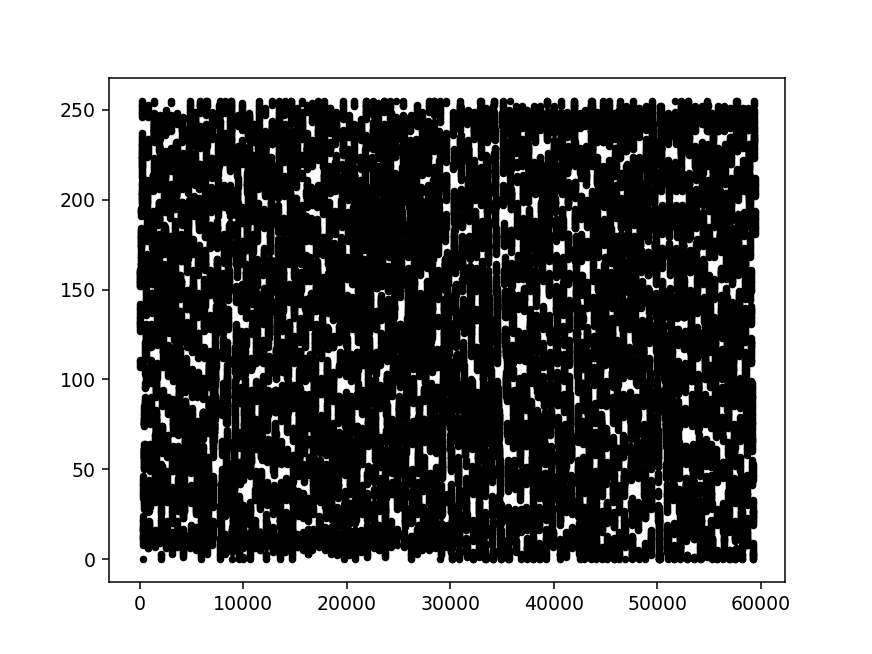

<IPython.core.display.Javascript object>


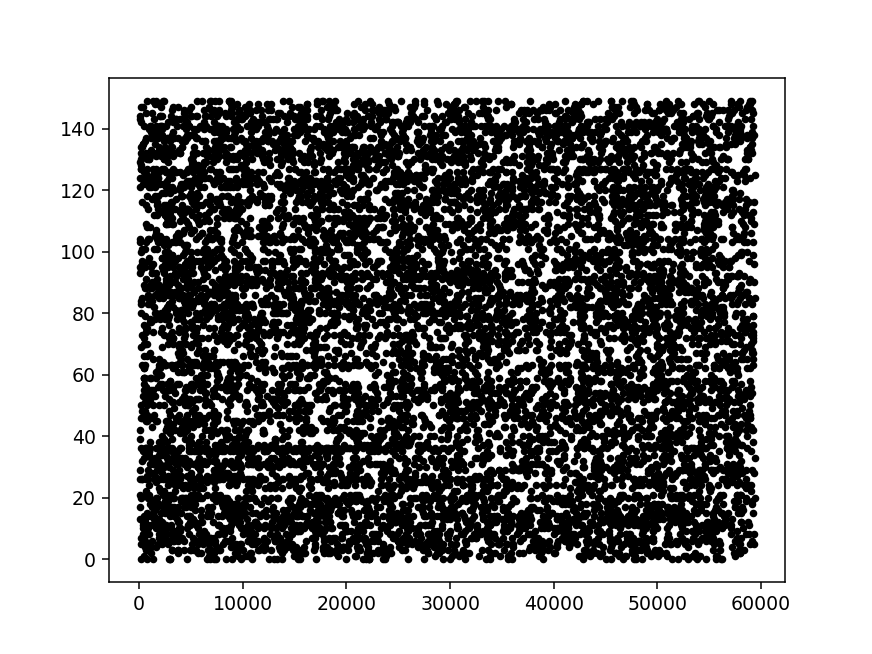

<IPython.core.display.Javascript object>


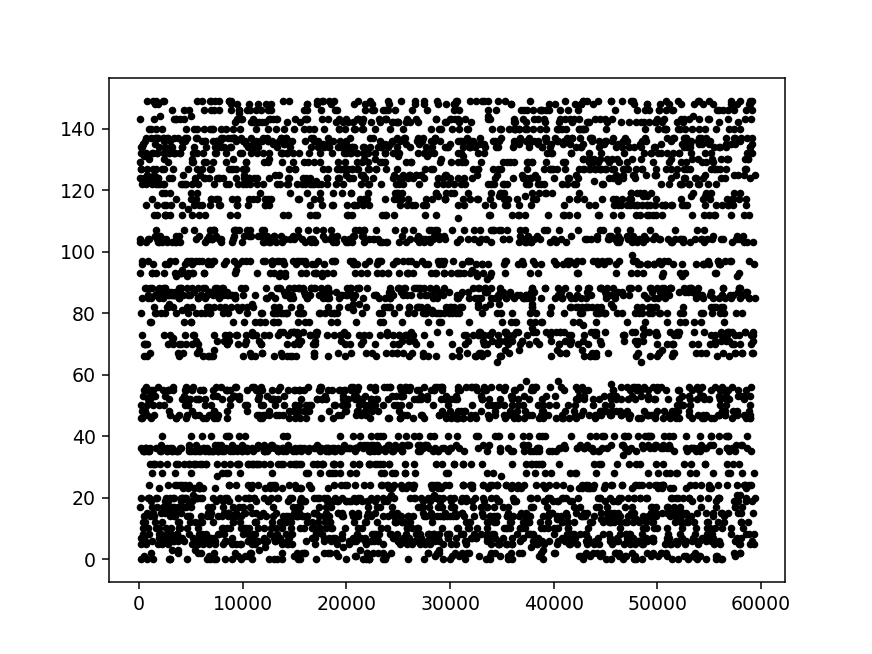

In [10]:
figure(4)
plot(spikemon3.t/ms, spikemon3.i, '.k')

figure(5)
plot(spikemon1.t/ms, spikemon1.i, '.k')
#plot(M.t/ms, M.v[0], label='Neuron 0')
#plot(M.t/ms, M.v[1], label='Neuron 1')
#xlabel('Time (ms)')
#ylabel('v')
#legend();

figure(6)
plot(spikemon2.t/ms, spikemon2.i, '.k')


In [26]:
min([0, 1, -2])

-2

In [11]:
Apre = 0
Apost = 0
#start_scope()

MapD=np.zeros(150)


s1 = SpikeMonitor(E)
data, answers =data_generator(40, state_change=0.05, left=0, right=1, noise=0.00, loop_around=True)
for j in range(len(data)):
        #S.I=np.concatenate((S.I[255:511], [f[0]*3for f in data[j]]), axis=None)
        S.I=[f[0]*3for f in data[j]]
        run(33*ms)
for i in s1.i:
    MapD[i]+=1

s2 = SpikeMonitor(E)
data, answers =data_generator(40, state_change=0.05, left=0, right=1, noise=0.00, loop_around=True)
for j in range(len(data)):
        #S.I=np.concatenate((S.I[255:511], [f[0]*3for f in data[j]]), axis=None)
        S.I=[f[0]*3for f in data[j]]
        run(33*ms)
for i in s2.i:
    MapD[i]-=1
setV=0
MinD=min(MapD)-10
Map=np.zeros(len(MapD))
for e in range(len(MapD)):
    ind=np.argmax(MapD)
    MapD[ind]=MinD
    Map[ind]=setV
    setV+=1
    
print(Map)

[ 46. 131.   9. 132.  88.  47.  89.  20.  10.  90.  21.  91.  22.  48.
  49.  11.  50. 149.  23.  24.  92.  51.  93.  94.  25.  95.  52.   1.
  53.  26.  96. 144. 133.  97.  98.  12.  99.  27. 100. 101.  54. 102.
 134.  55. 103. 145. 104. 105.  13.  56.  14. 106. 135.   0.  28.  57.
 107. 136. 108.  58.  29. 146.  59.  60. 137. 109.  15.  30. 110.  31.
  32.  61.  62. 111.  63. 112.  33.  34.  64.  35.  65. 113.  16.  66.
 114.  67.   2.  68.   3. 115.  69.  17.  70.  71.  72.   4.  36. 138.
  73.  74.   5. 139. 116.  37. 117.  18.  75.  76. 118.  77. 119.  78.
 120.   6.  38. 121. 140. 122. 123. 147.  39.  79. 141. 124.  80.  81.
  82. 125.  83.  40.  84.  85.  19. 142. 126. 127.  86.   7. 128. 129.
 148.   8.  41.  42.  43.  87.  44. 143.  45. 130.]


<IPython.core.display.Javascript object>


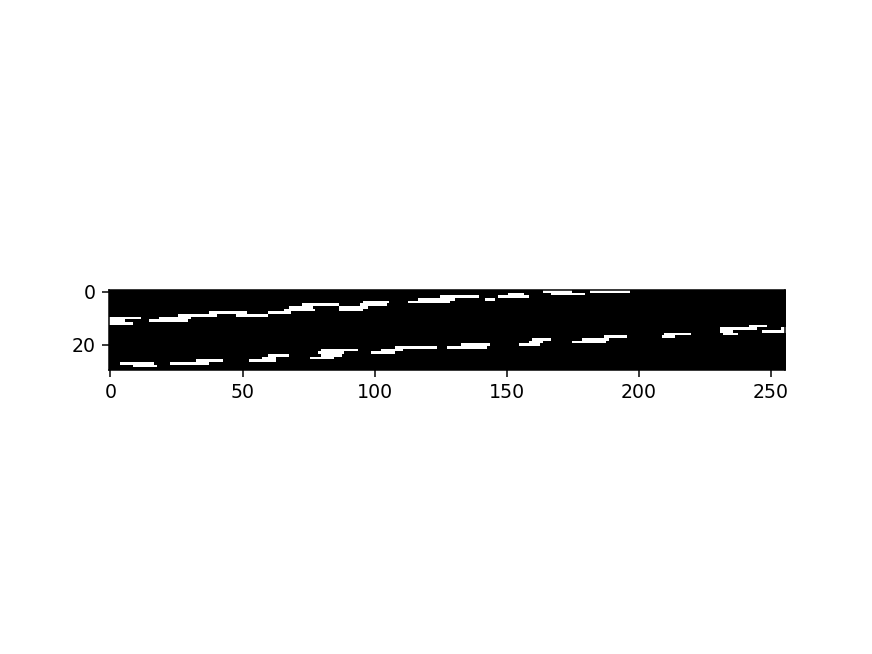

In [14]:
data, awnsder=data_generator(30, state_change=0.05, left=1, right=0, noise=0.00, loop_around=True)
figure(9)

imgplot = plt.imshow(data)

30


<IPython.core.display.Javascript object>


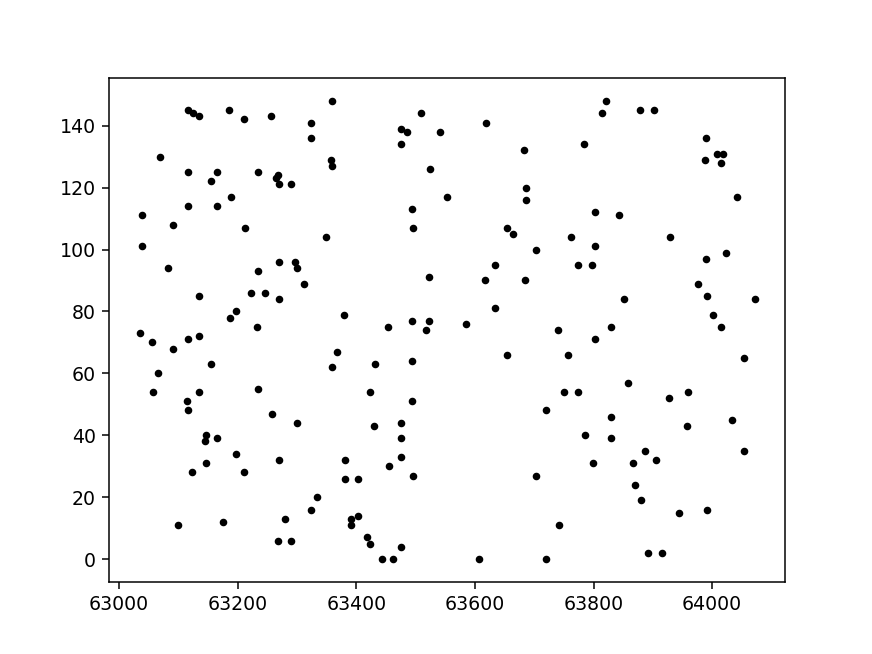

In [16]:
Apre = 0
Apost = 0
#start_scope()




#spid = SpikeMonitor(E)

#data, answers = data_generator(objects=1, sample_rate=30, time=4, label_delay=0, noise=0.00, left=0.3, right=0.3, loop_around=True)
print(len(data))
for j in range(len(data)):
        #S.I=np.concatenate((S.I[255:511], [f[0]*3for f in data[j]]), axis=None)
        S.I=[f[0]*3for f in data[j]]
        run(33*ms)
d=np.zeros(len(spid.i))
for e in range(len(spid.i)):
    d[e]=Map[spid.i[e]]
figure(8)
plot(spid.t/ms, d, '.k')

plt.show()
#print(answers['left']-answers['right'])

In [27]:
d=np.zeros(len(spi.i))
for e in range(len(spi.i)):
    d[e]=Map[spi.i[e]]-1
figure(19)
plot(spi.t/ms, spi.i, '.k')

plt.show()


NameError: name 'spi' is not defined

In [ ]:
figure(8)
plot(spikemon.t/ms, spikemon.i, '.k')
figure(9)
imgplot = plt.imshow(data)
plt.show()
print(answers['left']-answers['right'])

In [ ]:
Apre = 0
Apost = 0

In [25]:
data=np.asarray([StE.w, StE.delay, EtI.w])
np.savetxt('StEw.csv', StE.w, delimiter=',')
np.savetxt('StEdelay.csv', StE.delay, delimiter=',')
np.savetxt('EtIw.csv',  EtI.w, delimiter=',')
np.savetxt('Map.csv',  Map, delimiter=',')